# Praca domowa 4
#### Mateusz Grzyb

## Wczytanie bibliotek

In [1]:
import numpy as np
import pandas as pd
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder 

from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

import time

## Wczytanie zbiorów danych

### Zbiór 'apartments'
Źródło: pakiet DALEX

Zmienna celu: 'm2.price'

In [2]:
apartments=pd.read_csv('apartments.csv')

apartments

,m2.price,construction.year,surface,floor,no.rooms,district
0,5897,1953,25,3,1,Srodmiescie
1,1818,1992,143,9,5,Bielany
2,3643,1937,56,1,2,Praga
3,3517,1995,93,7,3,Ochota
4,3013,1992,144,6,5,Mokotow
...,...,...,...,...,...,...
995,6355,1921,44,2,2,Srodmiescie
996,3422,1921,48,10,2,Bemowo
997,3098,1980,85,3,3,Bemowo
998,4192,1942,36,7,1,Zoliborz


In [3]:
apartments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
m2.price             1000 non-null int64
construction.year    1000 non-null int64
surface              1000 non-null int64
floor                1000 non-null int64
no.rooms             1000 non-null int64
district             1000 non-null object
dtypes: int64(5), object(1)
memory usage: 47.0+ KB


Zbiór zawiera 1000 obserwacji, 5 zmiennych numerycznych i 1 zmienną kategoryczną. Nie występują braki danych.

In [4]:
len(np.unique(apartments.district))

10

Zmienna kategoryczna 'district' zawiera 10 kategorii, nie jest to dużo, więc zastosuję kodowanie One-Hot.

In [5]:
ohe=OneHotEncoder(sparse=False)
temp=pd.DataFrame(ohe.fit_transform(apartments[['district']]))
temp.columns=ohe.get_feature_names(['district'])
apartments=pd.concat([apartments, temp], axis=1).drop('district', axis=1)

apartments

,m2.price,construction.year,surface,floor,no.rooms,district_Bemowo,district_Bielany,district_Mokotow,district_Ochota,district_Praga,district_Srodmiescie,district_Ursus,district_Ursynow,district_Wola,district_Zoliborz
0,5897,1953,25,3,1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1818,1992,143,9,5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3643,1937,56,1,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,3517,1995,93,7,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3013,1992,144,6,5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,6355,1921,44,2,2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
996,3422,1921,48,10,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,3098,1980,85,3,3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,4192,1942,36,7,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### Zbiór 'concrete'
Źródło: http://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength

Zmienna celu: 'Concrete compressive strength(MPa, megapascals)'

In [6]:
concrete=pd.read_csv('concrete.csv')

concrete

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [7]:
concrete.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
Cement (component 1)(kg in a m^3 mixture)                1030 non-null float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    1030 non-null float64
Fly Ash (component 3)(kg in a m^3 mixture)               1030 non-null float64
Water  (component 4)(kg in a m^3 mixture)                1030 non-null float64
Superplasticizer (component 5)(kg in a m^3 mixture)      1030 non-null float64
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     1030 non-null float64
Fine Aggregate (component 7)(kg in a m^3 mixture)        1030 non-null float64
Age (day)                                                1030 non-null int64
Concrete compressive strength(MPa, megapascals)          1030 non-null float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


Zbiór zawiera 1030 obserwacji, 9 zmiennych numerycznych. Nie występują braki danych.

Warto również zauważyć, że wszystkie zmienne, oprócz zmiennej celu i zmiennej 'Age', podane są w tej samej jednostce (kg in a m^3 mixture).

## Hipoteza i funkcja testująca

Na oficjalnej stronie pakietu sklearn przeczytać możemy:

> **Support Vector Machine algorithms are not scale invariant, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1. Note that the same scaling must be applied to the test vector to obtain meaningful results.**

W celu sprawdzenia prawdziwości tego stwierdzenia przygotuję funkcję testującą.

In [8]:
def cv_test(estimator, X, y, param_grid, scorer, tune_n_iter, tune_cv, n_splits=5, verbose=False):
    iteration=1
    
    rmses=[]
    r2s=[]
    best_estimators=[]
    
    cv=KFold(n_splits=n_splits, shuffle=True)
   
    random=RandomizedSearchCV(estimator=estimator, param_distributions=param_grid, scoring=scorer, n_iter=tune_n_iter, cv=tune_cv, n_jobs=-1, verbose=verbose)

    for i, (train, test) in enumerate(cv.split(X, y)):
        if(verbose):
            print('Iteration: '+str(iteration))
        
        random_result=random.fit(X.iloc[train, ], y.iloc[train, ])
        best_estimator=random_result.best_estimator_
        
        prediction=best_estimator.predict(X.iloc[test, ])
        
        rmse=mean_squared_error(y.iloc[test, ], prediction, squared=False)
        r2=r2_score(y.iloc[test, ], prediction)
        
        rmses.append(rmse)
        r2s.append(r2)
        best_estimators.append(estimator)
        
        iteration+=1
        
    return rmses, r2s

Funkcja ta dokonuje 'n_splits' (domyślnie 5) podziałów podanego zbioru na zbiór treningowy i testowy (kroswalidacja). Dla każdego podziału podany model jest uczony i dostrajany na podzbiorze treningowym przez funkcję RandomizedSearchCV, z użyciem parametrów 'param_grid', 'scorer', 'tune_n_iter' i 'tune_cv'. Następnie dokonywana jest predykcja na podzbiorze testowym, z użyciem najlepszego modelu, jaki udało się uzyskać. Na jej podstawie, obliczane są miary RMSE i R2. Na koniec działania, funkcja zwraca listy miar RMSE i R2 z każdej iteracji. Argument 'verbose' odpowiada za informowanie o postępie.

## Testy i zebranie wyników

Przy użyciu powyższej funkcji, przetestuję model SVR oraz jego pipeline'y z funkcjami skalującymi StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, PowerTransformer i QuantileTransformer, dla obydwu zbiorów.

Wyniki będę zapisywać w tabeli 'results'.

In [37]:
columns=['dataset', 'scaler', 'iteration', 'rmse', 'r2']
results=pd.DataFrame(columns=columns)

results

,dataset,scaler,iteration,rmse,r2


### Zbiór 'apartments'

In [38]:
# uzywam make_pipeline, by uniknac przecieku danych
# uzywam ColumnTransformer, by nie skalowac kolumn, powstalych w wyniku kodowania
estimators=[make_pipeline(SVR()),
           make_pipeline(ColumnTransformer([('somename', StandardScaler(), ['construction.year', 'surface', 'floor', 'no.rooms'])], remainder='passthrough'), SVR()),
           make_pipeline(ColumnTransformer([('somename', MinMaxScaler(), ['construction.year', 'surface', 'floor', 'no.rooms'])], remainder='passthrough'), SVR()),
           make_pipeline(ColumnTransformer([('somename', MaxAbsScaler(), ['construction.year', 'surface', 'floor', 'no.rooms'])], remainder='passthrough'), SVR()),
           make_pipeline(ColumnTransformer([('somename', RobustScaler(), ['construction.year', 'surface', 'floor', 'no.rooms'])], remainder='passthrough'), SVR()),
           make_pipeline(ColumnTransformer([('somename', PowerTransformer(), ['construction.year', 'surface', 'floor', 'no.rooms'])], remainder='passthrough'), SVR()),
           make_pipeline(ColumnTransformer([('somename', QuantileTransformer(n_quantiles=len(apartments)/2), ['construction.year', 'surface', 'floor', 'no.rooms'])], remainder='passthrough'), SVR())]

# param_grid inspirowany artykułem: https://scikit-learn.org/stable/modules/grid_search.html
# tylko jadro gaussowskie, niestety, inne jadra dzialaja u mnie zbyt wolno
param_grid={'svr__C': sp.stats.expon(scale=100), 'svr__gamma': sp.stats.expon(scale=.1)}
scorer=make_scorer(r2_score, greater_is_better=True)

# do strojenia uzyje miary r2, jej zaleta jest porownywalnosc dla roznych zbiorow (w przeciwienstwie do rmse)
X=apartments.drop('m2.price', axis=1)
y=apartments['m2.price']

stage_names=['no_scaler', 'StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler', 'PowerTransformer', 'QuantileTransformer']

n=5

for i in range(len(estimators)):
    print('Stage: '+stage_names[i])
    start_time = time.time()
    
    estimator=estimators[i]
    rmses, r2s=cv_test(estimator=estimator, X=X, y=y, scorer=scorer, param_grid=param_grid, tune_n_iter=100, tune_cv=3, n_splits=n)

    for j in range(n):
        results=results.append(pd.DataFrame({'dataset': ['apartments'], 'scaler': [stage_names[i]], 'iteration': [j+1], 'rmse': [rmses[j]], 'r2': [r2s[j]]}))
    
    elapsed_time=time.time()-start_time
    print('Stage time: '+str(round(elapsed_time, 2))+'s\n')

Stage: no_scaler
Stage time: 7.76s

Stage: StandardScaler
Stage time: 8.47s

Stage: MinMaxScaler
Stage time: 8.41s

Stage: MaxAbsScaler
Stage time: 8.45s

Stage: RobustScaler
Stage time: 8.85s

Stage: PowerTransformer
Stage time: 11.32s

Stage: QuantileTransformer
Stage time: 8.72s



### Zbiór 'concrete'

In [39]:
# uzywam make_pipeline, by uniknac przecieku danych
estimators=[make_pipeline(SVR()),
           make_pipeline(StandardScaler(), SVR()),
           make_pipeline(MinMaxScaler(), SVR()),
           make_pipeline(MaxAbsScaler(), SVR()),
           make_pipeline(RobustScaler(), SVR()),
           make_pipeline(PowerTransformer(), SVR()),
           make_pipeline(QuantileTransformer(n_quantiles=len(concrete)/2), SVR())]

# param_grid inspirowany artykułem: https://scikit-learn.org/stable/modules/grid_search.html
# tylko jadro gaussowskie, niestety, inne jadra dzialaja u mnie zbyt wolno
param_grid={'svr__C': sp.stats.expon(scale=100), 'svr__gamma': sp.stats.expon(scale=.1)}
scorer=make_scorer(r2_score, greater_is_better=True)

# do strojenia uzyje miary r2, jej zaleta jest porownywalnosc dla roznych zbiorow (w przeciwienstwie do rmse)
X=concrete.drop('Concrete compressive strength(MPa, megapascals) ', axis=1)
y=concrete['Concrete compressive strength(MPa, megapascals) ']

stage_names=['no_scaler', 'StandardScaler', 'MinMaxScaler', 'MaxAbsScaler', 'RobustScaler', 'PowerTransformer', 'QuantileTransformer']

n=5

for i in range(len(estimators)):
    print('Stage: '+stage_names[i])
    start_time = time.time()
    
    estimator=estimators[i]
    rmses, r2s=cv_test(estimator=estimator, X=X, y=y, scorer=scorer, param_grid=param_grid, tune_n_iter=100, tune_cv=3, n_splits=5)

    for j in range(n):
        results=results.append(pd.DataFrame({'dataset': ['concrete'], 'scaler': [stage_names[i]], 'iteration': [j+1], 'rmse': [rmses[j]], 'r2': [r2s[j]]}))
    
    elapsed_time=time.time()-start_time
    print('Stage time: '+str(round(elapsed_time, 2))+'s\n')

Stage: no_scaler
Stage time: 10.68s

Stage: StandardScaler
Stage time: 15.55s

Stage: MinMaxScaler
Stage time: 9.25s

Stage: MaxAbsScaler
Stage time: 8.24s

Stage: RobustScaler
Stage time: 14.32s

Stage: PowerTransformer
Stage time: 23.9s

Stage: QuantileTransformer
Stage time: 10.47s



## Surowe wyniki

In [53]:
pd.set_option('display.max_rows', 100)

# nacisnij na trzykropek, by rozwinac
results

,dataset,scaler,iteration,rmse,r2
0,apartments,no_scaler,1,779.553162,0.240187
0,apartments,no_scaler,2,734.168943,0.360334
0,apartments,no_scaler,3,716.212924,0.350806
0,apartments,no_scaler,4,799.808039,0.267441
0,apartments,no_scaler,5,723.802150,0.335782
0,apartments,StandardScaler,1,177.641841,0.960534
0,apartments,StandardScaler,2,173.038072,0.961183
0,apartments,StandardScaler,3,182.666935,0.958949
0,apartments,StandardScaler,4,183.698181,0.962863
0,apartments,StandardScaler,5,180.093023,0.959515


## Wizualizacja wyników i podsumowanie

### Zbiór 'apartments'

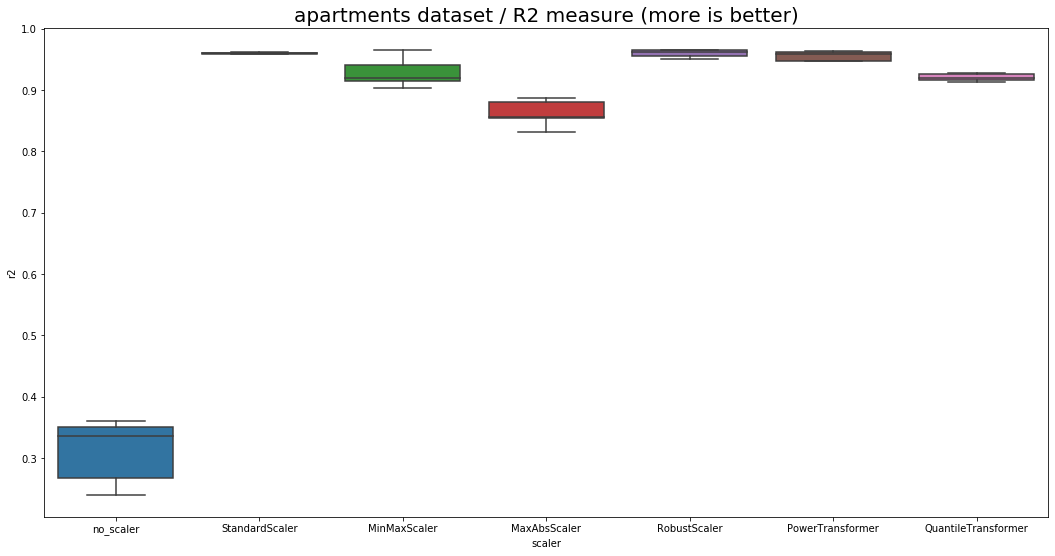

In [40]:
plt.figure(figsize=(18, 9))
ax=sns.boxplot(x="scaler", y="r2", data=results[results.dataset=='apartments']).set_title('apartments dataset / R2 measure (more is better)', fontsize=20)
plt.show()

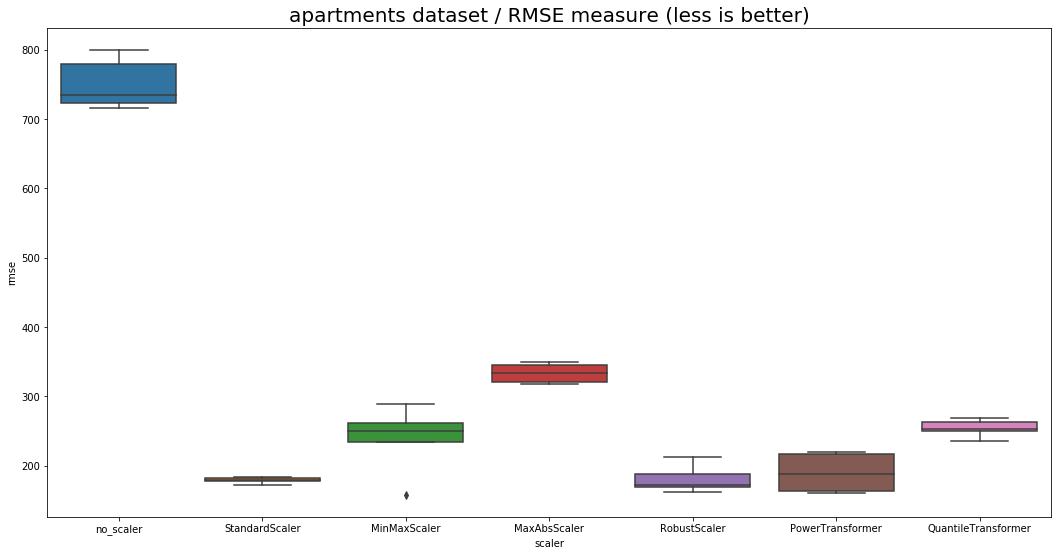

In [41]:
plt.figure(figsize=(18, 9))
ax=sns.boxplot(x="scaler", y="rmse", data=results[results.dataset=='apartments']).set_title('apartments dataset / RMSE measure (less is better)', fontsize=20)
plt.show()

### Zbiór 'concrete'

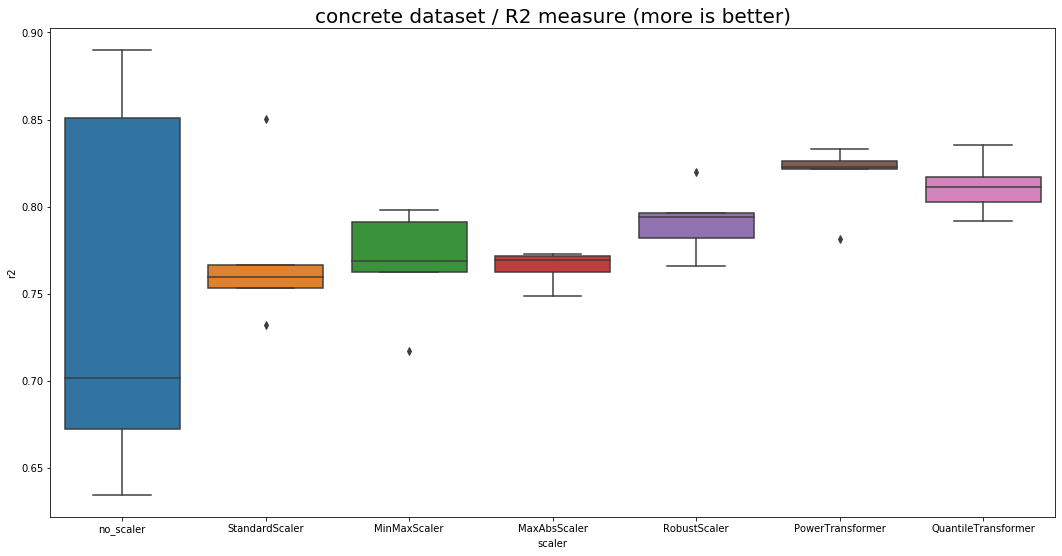

In [42]:
plt.figure(figsize=(18, 9))
ax=sns.boxplot(x="scaler", y="r2", data=results[results.dataset=='concrete']).set_title('concrete dataset / R2 measure (more is better)', fontsize=20)
plt.show()

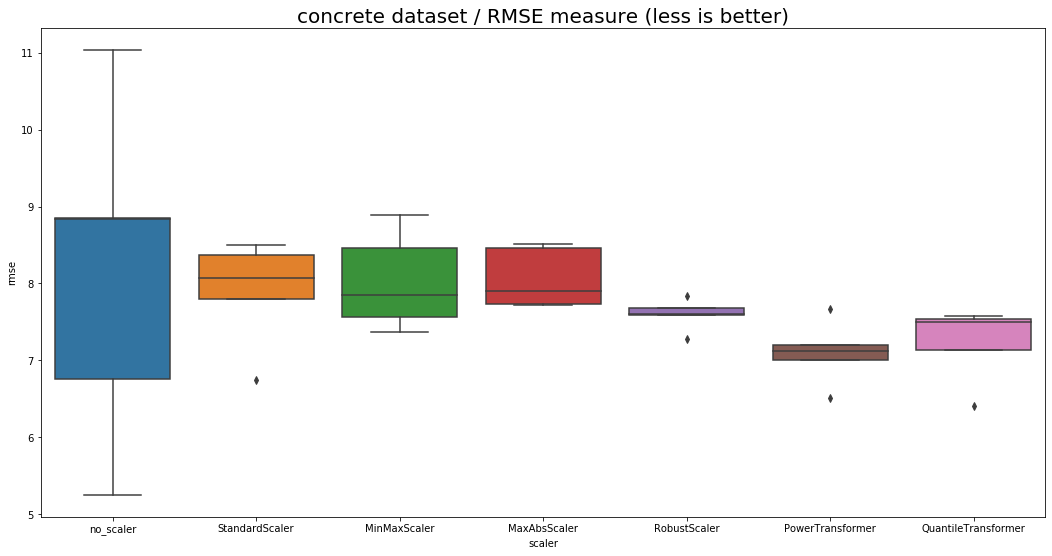

In [44]:
plt.figure(figsize=(18, 9))
ax=sns.boxplot(x="scaler", y="rmse", data=results[results.dataset=='concrete']).set_title('concrete dataset / RMSE measure (less is better)', fontsize=20)
plt.show()

### Podsumowanie wyników

Powyższe wykresy zdecydowanie potwierdzają duże korzyści, jakie wiążą się ze skalowaniem danych, podczas używania algorytmu **Support Vector Machine**. Skalowanie danych wpływa pozytywnie zarówno na wartości wyników (szczególnie widoczne na zbiorze 'apartments'), jak i na ich stabilność (szczególnie widoczne na zbiorze 'concrete'). Dowolna metoda skalowania daje dużą przewagę, w porównaniu z brakiem jakiejkolwiek transformacji, jednak, jak ilustrują wykresy, ważne jest również dobranie metody odpowiedniej dla danego zbioru danych (dla zbioru 'apartments' najlepszy okazał się RobustScaler, a dla zbioru 'concrete' - PowerTransformer).